# Introduction

**Problem Statement**<br>
* Cross-sell PredictionPredict Health Insurance Owners' who will be interested in Vehicle Insurance<br>
* 1 : Customer is interested, 0 : Customer is not interested

**Data**<br>
* Setiap baris mewakili data customer.<br>

**Link Kaggle**<br>
* https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Collection

## Load Data

In [2]:
data = pd.read_csv('input/train.csv')
data = data.drop('id', axis=1)
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
data['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [4]:
# X = data.drop(['Class','Name'],axis=1)
# y = data['Class']
# # Overampling with SMOTE
# X_over_smote, y_over_smote = over_sampling.SMOTE().fit_resample(X, y)

# Data Understanding

## Data Description

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


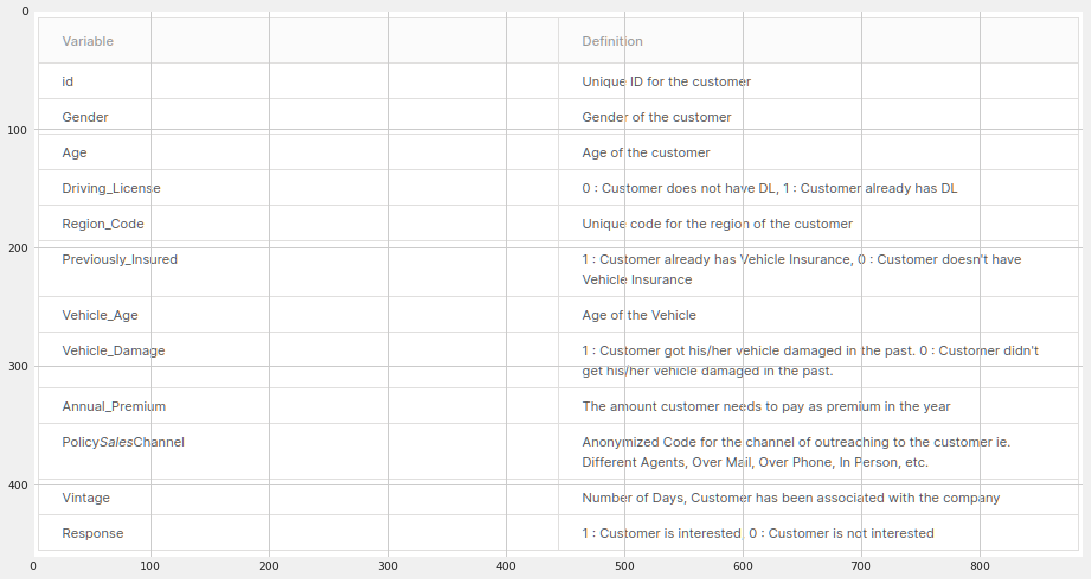

In [6]:
data_description = cv2.imread('fig/data_description.png')
plt.imshow(data_description)
plt.tight_layout()
plt.show()

## Numerical Data

In [7]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data.select_dtypes(include=numerics).columns)
print(data.select_dtypes(include=numerics).shape)
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

(381109, 8)


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,44,1,28.0,0,40454.0,26.0,217,1
1,76,1,3.0,0,33536.0,26.0,183,0
2,47,1,28.0,0,38294.0,26.0,27,1


## Non Numerical Data

In [8]:
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

(381109, 3)


,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes


# Data Pre-Processing

## Missing Value

In [9]:
data_missing_value = data.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(data))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage


**Tidak ada missing value, artinya semua fitur memiliki nilai yang lengkap**

## Duplicate Values

In [10]:
data.duplicated().sum()

269

**remove duplicate values**

In [11]:
print('Total Row : ', len(data))
data = data.drop_duplicates()
print('Total Row after drop duplicates : ', len(data))

Total Row :  381109
Total Row after drop duplicates :  380840


In [12]:
# double check 
381109 - 269

380840

## Statistical Summary

In [13]:
data_num.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [14]:
data_cat.describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


## Outlier

In [15]:
# features = ['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']
# data_num = data_num[features]
# k = len(data_num.columns)
# n = 3
# m = (k - 1) // n + 1
# fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
# for i, (name, col) in enumerate(data_num.iteritems()):
#     r, c = i // n, i % n
#     ax = axes[r, c]
#     col.hist(ax=ax, color='green')
#     ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
#     ax2.set_ylim(0)

# fig.tight_layout()

In [16]:
# plt.figure(figsize=(15, 7))
# for i in range(0, len(features)):
#     plt.subplot(1, 7, i+1)
#     sns.boxplot(data[features[i]],color='green',orient='v')
#     plt.tight_layout()

In [17]:
data['Annual_Premium'] = np.log(data['Annual_Premium']+1)

## Feature encoding

In [18]:
dummies_Gender = pd.get_dummies(data['Gender'],prefix='Gender')
dummies_Vehicle_Age = pd.get_dummies(data['Vehicle_Age'],prefix='Vehicle_Age')
dummies_Vehicle_Damage = pd.get_dummies(data['Vehicle_Damage'],prefix='Vehicle_Damage')

In [19]:
data = pd.concat([data, dummies_Gender,dummies_Vehicle_Age,dummies_Vehicle_Damage], axis=1)

## Correlation Matrix

In [20]:
# plt.figure(figsize = (18, 16))
# sns.heatmap(data.corr(), annot=True, cmap='BuPu')
# plt.show()

## Feature Selection

In [21]:
data = data.drop(['Gender','Vehicle_Age','Vehicle_Damage'], axis=1)

## Sampling Dataset

In [22]:
list(data)

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_Female',
 'Gender_Male',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Age_> 2 Years',
 'Vehicle_Damage_No',
 'Vehicle_Damage_Yes']

In [23]:
data.columns = ['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_Female',
 'Gender_Male',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_less_than_1Year',
 'Vehicle_Age_greater_than_2_Years',
 'Vehicle_Damage_No',
 'Vehicle_Damage_Yes']

In [24]:
# ['Gender',
#  'Age',
#  'Driving_License',
#  'Region_Code',
#  'Previously_Insured',
#  'Annual_Premium',
#  'Policy_Sales_Channel',
#  'Vintage',
#  'Response',
#  'Vehicle_Age_lt_1_Year',
#  'Vehicle_Age_gt_2_Years',
#  'Vehicle_Damage_Yes']

In [25]:
col=['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'Gender_Female',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_less_than_1Year',
 'Vehicle_Age_greater_than_2_Years',
 'Vehicle_Damage_Yes']

In [26]:
data = data[col]

In [27]:
data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Vehicle_Age_1-2 Year,Vehicle_Age_less_than_1Year,Vehicle_Age_greater_than_2_Years,Vehicle_Damage_Yes
0,44,1,28.0,0,10.607946,26.0,217,1,0,0,0,1,1
1,76,1,3.0,0,10.420405,26.0,183,0,0,1,0,0,0
2,47,1,28.0,0,10.553075,26.0,27,1,0,0,0,1,1
3,21,1,11.0,1,10.261861,152.0,203,0,0,0,1,0,0
4,29,1,41.0,1,10.221832,152.0,39,0,1,0,1,0,0


## Scaling

In [28]:
# separating the independent and dependent variables

y = data['Response'].values
X = data.drop(labels = ['Response'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (380840, 12) and that of y is (380840,)


In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

ss = StandardScaler()
X_std = ss.fit_transform(X)

In [ ]:
1000rb GAP         1M

0 1

0.00000001   1



In [30]:
# Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of training set  (304672, 12)
Shape of test set  (76168, 12)


# Modeling and Evaluation

## Pre - modeling

In [31]:
classifications = [LogisticRegression(),
                  DecisionTreeClassifier(),
                  RandomForestClassifier()
                 ]

result_model = pd.DataFrame(columns = ['Method', 'roc_auc_score'])
result_model

In [32]:
for model in classifications:
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:,1]
    
    y_score_train = model.predict_proba(X_train)[:,1]
    
    method = str(type(model)).split('.')[-1][:-2]

    
    #roc_auc_score test
    roc_auc_score_test = roc_auc_score(y_test, y_score)
    roc_auc_score_test = roc_auc_score_test.item()
    
    #
    roc_auc_score_train = roc_auc_score(y_test, y_score)
    roc_auc_score_train = roc_auc_score_test.item()
    
    
    
    

    result_model = result_model.append({'Method': method,
                    'roc_auc_score': roc_auc_score_},
                     ignore_index=True)

In [ ]:
test -> real -> history -> impact -> %

In [ ]:
deplot-> rilis (E)

In [ ]:
minitoring model -> $

## Fix modeling

### RandomForestClassifier

In [35]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

### Tunning parameter

### Evaluasi

# Insight

In [38]:
clf.feature_importances_

array([0.14303153, 0.00050116, 0.11186176, 0.05556868, 0.25023807,
       0.06616243, 0.27850656, 0.00903035, 0.00592097, 0.00903057,
       0.00207981, 0.06806811])

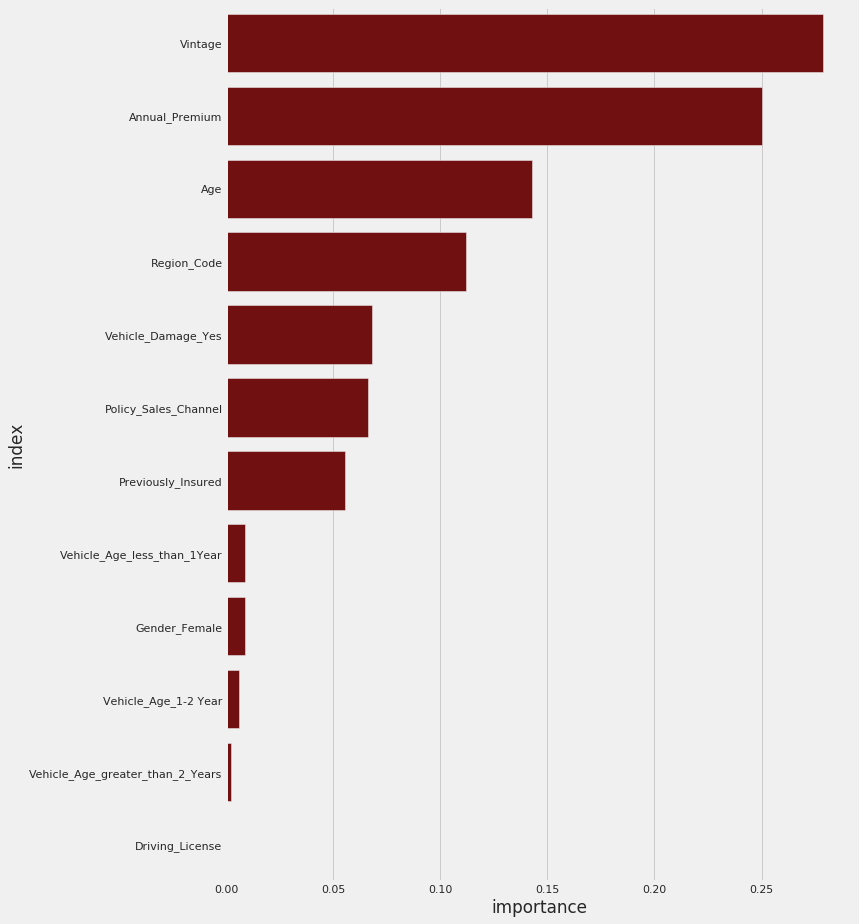

In [37]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,15))
sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index())

In [ ]:
0 no
1 resp

vintage
0 baru
1 lama